In [9]:
import torch
import torch.nn as nn

import numpy as np
import copy
import random

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
%load_ext autoreload
%autoreload 2
import sine_data_generator
import models.encoder
import models.decoder

from sine_data_generator import SineDataGenerator
from models.encoder import IOPairSetEncoder
from models.decoder import Decoder
from models.lpn import LPN
from models.utils import relu_seq, ReluNet, make_leave_one_out

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [10]:
def generate_extrapolation_batch(data_gen, n_support, n_query):
    """
    Draws one task and splits its samples into:
      • support points with x < 0  (n_support of them)
      • query   points with x >= 0 (n_query of them)

    Returns:
      support_xs: (1, n_support, 1)
      support_ys: (1, n_support, 1)
      query_xs:   (1, n_query,   1)
      query_ys:   (1, n_query,   1)
      amp, phase: floats
    """
    xs, ys, amp, phase = data_gen.generate()  # shapes: (B, N, 1) and (B,)
    # select first task if batch_size>1
    xs = xs[0]       # → (N,1)
    ys = ys[0]       # → (N,1)
    amp   = amp[0].item()
    phase = phase[0].item()

    neg_idx = (xs[:,0] < 0).nonzero(as_tuple=False).squeeze()
    pos_idx = (xs[:,0] >= 0).nonzero(as_tuple=False).squeeze()

    support_idx = neg_idx[:n_support]
    query_idx   = pos_idx[:n_query]

    support_xs = xs[support_idx].unsqueeze(0)  # (1, n_support, 1)
    support_ys = ys[support_idx].unsqueeze(0)
    query_xs   = xs[query_idx].unsqueeze(0)    # (1, n_query,   1)
    query_ys   = ys[query_idx].unsqueeze(0)

    return support_xs, support_ys, query_xs, query_ys, amp, phase


In [11]:
n_test_points = 60
test_batch_size = 1
n_query = 20
n_support = 10
n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task

In [12]:
data_gen = SineDataGenerator(num_samples_per_class=n_support + n_query,
                             batch_size=1)


inputs_np, outputs_np, amp_np, phase_np = data = data_gen.generate()
xs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data]

### Modules

#### Encoder

In [13]:
io_pairs = torch.cat([xs, outputs_pred], dim=-1)  # (batch_size, N, 2)
io_pairs.shape

torch.Size([1, 30, 2])

In [14]:
set_encoder = IOPairSetEncoder()
z_mu, z_logvar = set_encoder(io_pairs)
z_sample = z_mu
z_sample.shape  # (batch_size, output_dim)

torch.Size([1, 3])

#### Decoder

In [15]:
input_0 = xs[:, 0, :]  # (batch_size, d_input)
input_0.shape

torch.Size([1, 1])

In [16]:
z_expanded = z_sample.unsqueeze(1).expand(-1, xs.size(1), -1)
z_inputs = torch.cat([z_expanded, xs], axis=-1)
z_inputs.shape

torch.Size([1, 30, 4])

In [17]:
decoder = Decoder()
decoder

Decoder(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [18]:
decoder(z_inputs).shape

torch.Size([1, 30, 1])

### Utils

In [19]:
def make_leave_one_out(array: torch.Tensor, axis: int) -> torch.Tensor:
    """
    Args:
        array: Tensor of shape (*B, N, *H).
        axis: The axis where N appears.

    Returns:
        Tensor of shape (*B, N, N-1, *H).
    """
    axis = axis % array.ndim
    n = array.size(axis)
    output = []

    for i in range(n):
        array_before = array.narrow(axis, 0, i)
        array_after = array.narrow(axis, i + 1, n - i - 1)
        sliced = torch.cat([array_before, array_after], dim=axis)
        output.append(sliced)

    output = torch.stack(output, dim=axis)
    return output

In [20]:
# Create a random tensor
random_array = torch.randn(4, 5, 6)  # Example shape (4, 5, 6)

# Apply the make_leave_one_out function
leave_one_out_result = make_leave_one_out(random_array, axis=1)

# Print the shapes to verify
print("Original shape:", random_array.shape)
print("Leave-one-out shape:", leave_one_out_result.shape)

Original shape: torch.Size([4, 5, 6])
Leave-one-out shape: torch.Size([4, 5, 4, 6])


In [19]:
random_array[0, :, :]

tensor([[-2.0245,  1.2739,  0.1611, -0.3323, -0.2750,  0.8881],
        [ 0.7396,  0.3042, -0.9771, -0.8871,  1.3345,  0.8276],
        [ 1.3554,  0.9643, -0.6711,  0.5168,  0.3140,  0.9722],
        [ 0.2972, -0.0080,  0.4293, -0.0542, -1.3653,  0.9496],
        [-1.1620, -1.5015,  0.1421,  1.0663, -0.5832, -1.6393]])

In [20]:
leave_one_out_result[0, 0, :, :]

tensor([[ 0.7396,  0.3042, -0.9771, -0.8871,  1.3345,  0.8276],
        [ 1.3554,  0.9643, -0.6711,  0.5168,  0.3140,  0.9722],
        [ 0.2972, -0.0080,  0.4293, -0.0542, -1.3653,  0.9496],
        [-1.1620, -1.5015,  0.1421,  1.0663, -0.5832, -1.6393]])

### LPN

In [21]:
# z: (H,)
# inputs: (B, 1)
B = 3  # Batch size
N = 5
H = 7  # Latent dimension

# Generate random z and inputs
z_init = torch.randn(H)  # Random latent variables of shape (B, H)
xs = torch.randn(B, 1)  # Random inputs of shape (B, 1)

# z_expanded = z.unsqueeze(0).expand(B, -1)
z_init.unsqueeze(0).expand(B, -1).shape

torch.Size([3, 7])

In [22]:
torch.manual_seed(0)
ys_1 = torch.randn(B, N, N-1, 1)
ys_2 = torch.randn(B, N, N-1, 1)
mse = nn.functional.mse_loss(ys_1, ys_2, reduction='none') # (B, N, 1)
mse.sum(dim=-2).shape

torch.Size([3, 5, 1])

In [23]:
z_init = torch.randn(B, N, H)
z_init.unsqueeze(2).expand(-1, -1, N-1, -1).shape

torch.Size([3, 5, 4, 7])

### Training

In [24]:
import wandb
wandb.init(settings=wandb.Settings(save_code=False))
wandb.finish()
wandb.init(project="lpn4sine_cf_maml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_metaiter = 30_001
n_samples_per_task = 20
batch_size = 25

# number of inner gradient steps (in training)
numstep = 1

data_gen = SineDataGenerator(n_samples_per_task, batch_size)

# alpha = 4e-4

# Init encoder-decoder
# encoder = IOPairSetEncoder(phi=ReluNet(2, 32, 32),
#                            rho_0=ReluNet(32, 32, 16),
#                            rho_1=ReluNet(16, 8, d_latent))

# decoder = Decoder(d_input=1, d_latent=d_latent, ds_hidden=[32, 32], d_output=1)
d_latent = 4

encoder = IOPairSetEncoder(phi=ReluNet(2, 16, 32),
                           rho_0=ReluNet(32, 16, 16),
                           rho_1=ReluNet(16, 8, d_latent))

decoder = Decoder(d_input=1, d_latent=d_latent, ds_hidden=[16, 16, 16], d_output=1)

lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("Total parameters:", count_parameters(lpn))

optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)

losses = []

for i in range(n_metaiter):
    lpn.train()
    optimizer.zero_grad()

    xs, ys, amp, phase = data_gen.generate()
    io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)

    # keep randomness in training
    _, loss = lpn(io_pairs, K=numstep, debug=(i==0), deterministic=False)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        wandb.log({"loss": loss.item()})
        losses.append(loss.item())
    if i % 1000 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")


wandb.finish()

wandb: Currently logged in as: wkalikman (wkalikman-eth-zurich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total parameters: 2393
torch.sum(mse).item()=34688.20703125
Step 0, Loss: 1.8281
Step 1000, Loss: 0.9537
Step 2000, Loss: 0.2324
Step 3000, Loss: 0.3454
Step 4000, Loss: 0.1463
Step 5000, Loss: 0.1295
Step 6000, Loss: 0.1539
Step 7000, Loss: 0.0552
Step 8000, Loss: 0.0593
Step 9000, Loss: 0.0462
Step 10000, Loss: 0.0417
Step 11000, Loss: 0.0804
Step 12000, Loss: 0.0756
Step 13000, Loss: 0.0485
Step 14000, Loss: 0.0699
Step 15000, Loss: 0.0403
Step 16000, Loss: 0.0612
Step 17000, Loss: 0.0347
Step 18000, Loss: 0.0484
Step 19000, Loss: 0.0526
Step 20000, Loss: 0.0601
Step 21000, Loss: 0.0431
Step 22000, Loss: 0.0455
Step 23000, Loss: 0.0497
Step 24000, Loss: 0.0442
Step 25000, Loss: 0.0421
Step 26000, Loss: 0.0346
Step 27000, Loss: 0.0346
Step 28000, Loss: 0.0293
Step 29000, Loss: 0.0413
Step 30000, Loss: 0.0321


loss,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.03214


In [25]:
wandb.finish()

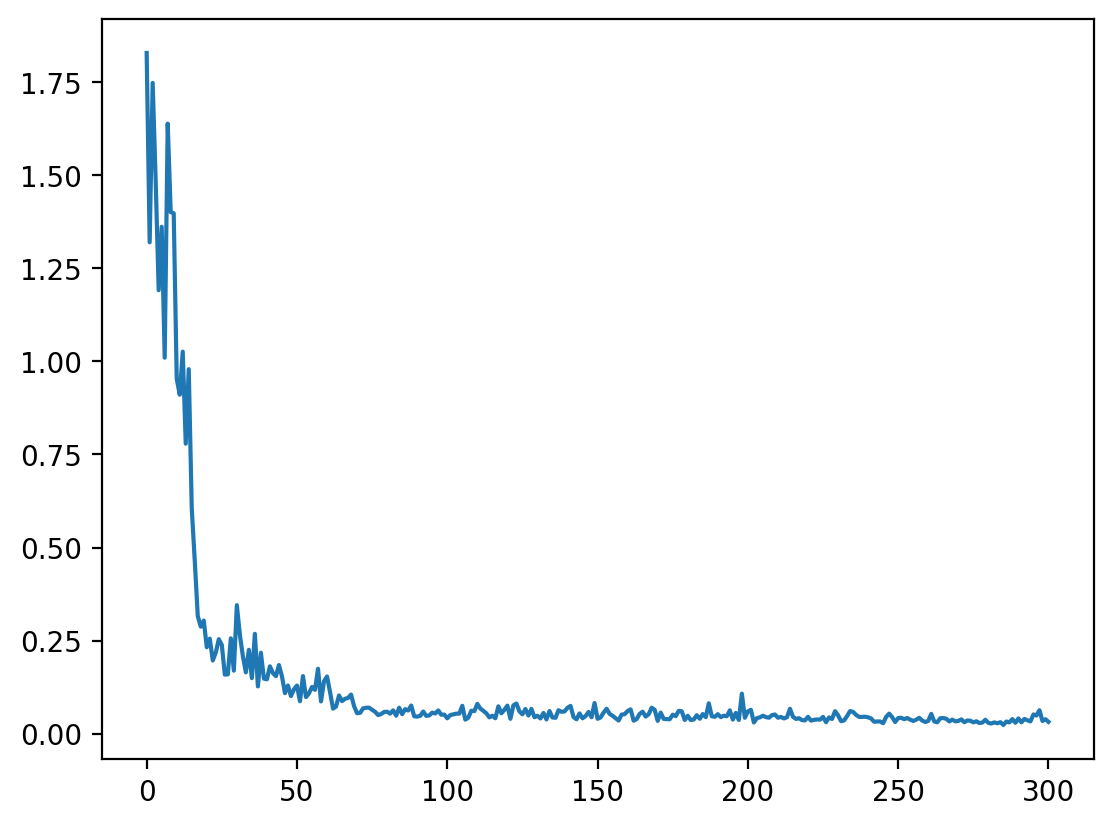

In [26]:
plt.plot(losses)
plt.show()

#### Testing: cf MAML

In [27]:
n_test_points = 60
test_batch_size = 1
n_test_samples_per_task = 20
n_support_samples_per_task = 10
n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task

test_numstep = 100

data_gen = SineDataGenerator(n_test_samples_per_task, test_batch_size)

np.random.seed(1)
random.seed(1)

metaeval_losses = np.full((n_test_points, test_numstep + 1), np.nan)

for i_test_task in range(n_test_points):
    support_xs, support_ys, query_xs, query_ys, amp, phase = \
    generate_extrapolation_batch(data_gen,
                                 n_support=n_support_samples_per_task,
                                 n_query=n_query_samples_per_task)


    support_pairs = torch.cat([support_xs, support_ys], dim=-1).to(device)  # (B, N, 2)
    aux_t, loss_t = lpn(support_pairs, K=test_numstep, debug=True, deterministic=True)

    y_pred = aux_t["ys_pred"].detach().cpu().numpy()
    z_mu = aux_t["z_mu"]
    z_logvar = aux_t["z_logvar"]
    # z_sample = aux_t["z_sample"].detach()
    # z_prime = aux_t["z_prime"].detach()
    z_traj = aux_t["z_traj"]

    z_sample = z_traj[0]
    z_prime = z_traj[-1]

    assert len(z_traj) == test_numstep + 1
    for i_step, z in enumerate(z_traj):
        z = z.mean(dim=1).squeeze(0)  # (d_latent,)
        assert z.shape == (d_latent,)

        # Evaluate MSE loss of z on the query set
        assert query_xs.shape == (test_batch_size, n_query_samples_per_task, 1)
        assert query_xs.squeeze(0).shape == (test_batch_size * n_query_samples_per_task, 1)
        query_ys_pred = lpn.decode(z, query_xs.squeeze(0).to(device))
        assert query_ys_pred.shape == (test_batch_size * n_query_samples_per_task, 1)
        mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')
        metaeval_losses[i_test_task, i_step] = mse.item()



torch.sum(mse).item()=139.77227783203125
torch.sum(mse).item()=25.07001304626465
torch.sum(mse).item()=5.946689605712891
torch.sum(mse).item()=2.3061275482177734
torch.sum(mse).item()=1.3611867427825928
torch.sum(mse).item()=1.0233421325683594
torch.sum(mse).item()=0.883418083190918
torch.sum(mse).item()=0.8118655681610107
torch.sum(mse).item()=0.7719665169715881
torch.sum(mse).item()=0.7486352324485779
torch.sum(mse).item()=0.7354058027267456
torch.sum(mse).item()=0.7274323105812073
torch.sum(mse).item()=0.7222334146499634
torch.sum(mse).item()=0.7185159921646118
torch.sum(mse).item()=0.7156493067741394
torch.sum(mse).item()=0.7132574319839478
torch.sum(mse).item()=0.7111337780952454
torch.sum(mse).item()=0.7091652154922485
torch.sum(mse).item()=0.7072871923446655
torch.sum(mse).item()=0.7054641842842102
torch.sum(mse).item()=0.7036758065223694
torch.sum(mse).item()=0.7019109725952148
torch.sum(mse).item()=0.7001653909683228
torch.sum(mse).item()=0.6984320282936096
torch.sum(mse).item

AssertionError: 

In [28]:
for z in z_traj:
    print(z.shape)

torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size(

### Save/reload weights

In [33]:
torch.save(lpn.state_dict(), f'lpn_H{d_latent}_GA{numstep}_cmp.pth')

In [34]:
lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)
state_dict = torch.load(f'lpn_H{d_latent}_GA{numstep}_cmp.pth')
lpn.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

### Micro-validation

In [35]:
# one batch, 10 examples
test_xs, test_ys, amp, phase = SineDataGenerator(10, 1).generate()

amp = amp.item()
phase = phase.item()

test_xs.shape

torch.Size([1, 10, 1])

In [36]:
io_pairs_t = torch.cat([test_xs, test_ys], dim=-1).to(device)  # (B, N, 2)
aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True, deterministic=True)

y_pred = aux_t["ys_pred"].detach().cpu().numpy()
z_mu = aux_t["z_mu"].detach()
z_logvar = aux_t["z_logvar"].detach()
z_sample = aux_t["z_sample"].detach()
z_prime = aux_t["z_prime"].detach()

torch.sum(mse).item()=7.008338928222656
torch.sum(mse).item()=4.987065315246582
torch.sum(mse).item()=3.7939600944519043
torch.sum(mse).item()=3.0084612369537354
torch.sum(mse).item()=2.4665985107421875
torch.sum(mse).item()=2.083646535873413
torch.sum(mse).item()=1.7991777658462524
torch.sum(mse).item()=1.5888630151748657
torch.sum(mse).item()=1.4334555864334106
torch.sum(mse).item()=1.315987467765808
torch.sum(mse).item()=1.2238578796386719
torch.sum(mse).item()=1.155646562576294
torch.sum(mse).item()=1.1048599481582642
torch.sum(mse).item()=1.0668895244598389
torch.sum(mse).item()=1.038375973701477
torch.sum(mse).item()=1.0168694257736206
torch.sum(mse).item()=1.0005407333374023
torch.sum(mse).item()=0.9879241585731506
torch.sum(mse).item()=0.9780514240264893
torch.sum(mse).item()=0.9704204797744751
torch.sum(mse).item()=0.9644522070884705
torch.sum(mse).item()=0.9597179889678955
torch.sum(mse).item()=0.9558994770050049
torch.sum(mse).item()=0.9527671933174133
torch.sum(mse).item()=

torch.sum(mse).item()=91.84468078613281
torch.sum(mse).item()=27.932689666748047
torch.sum(mse).item()=9.887468338012695
torch.sum(mse).item()=4.60288143157959
torch.sum(mse).item()=2.420518159866333
torch.sum(mse).item()=1.4942150115966797
torch.sum(mse).item()=1.0507981777191162
torch.sum(mse).item()=0.8174475431442261
torch.sum(mse).item()=0.6849365234375
torch.sum(mse).item()=0.6033226251602173
torch.sum(mse).item()=0.5514163970947266
torch.sum(mse).item()=0.5168732404708862
torch.sum(mse).item()=0.49223020672798157
torch.sum(mse).item()=0.47473543882369995
torch.sum(mse).item()=0.4625629782676697
torch.sum(mse).item()=0.4532262086868286
torch.sum(mse).item()=0.44650644063949585
torch.sum(mse).item()=0.44158005714416504
torch.sum(mse).item()=0.43796801567077637
torch.sum(mse).item()=0.43524765968322754
torch.sum(mse).item()=0.43307849764823914
torch.sum(mse).item()=0.4313476085662842
torch.sum(mse).item()=0.4298558831214905
torch.sum(mse).item()=0.4285714626312256
torch.sum(mse).it

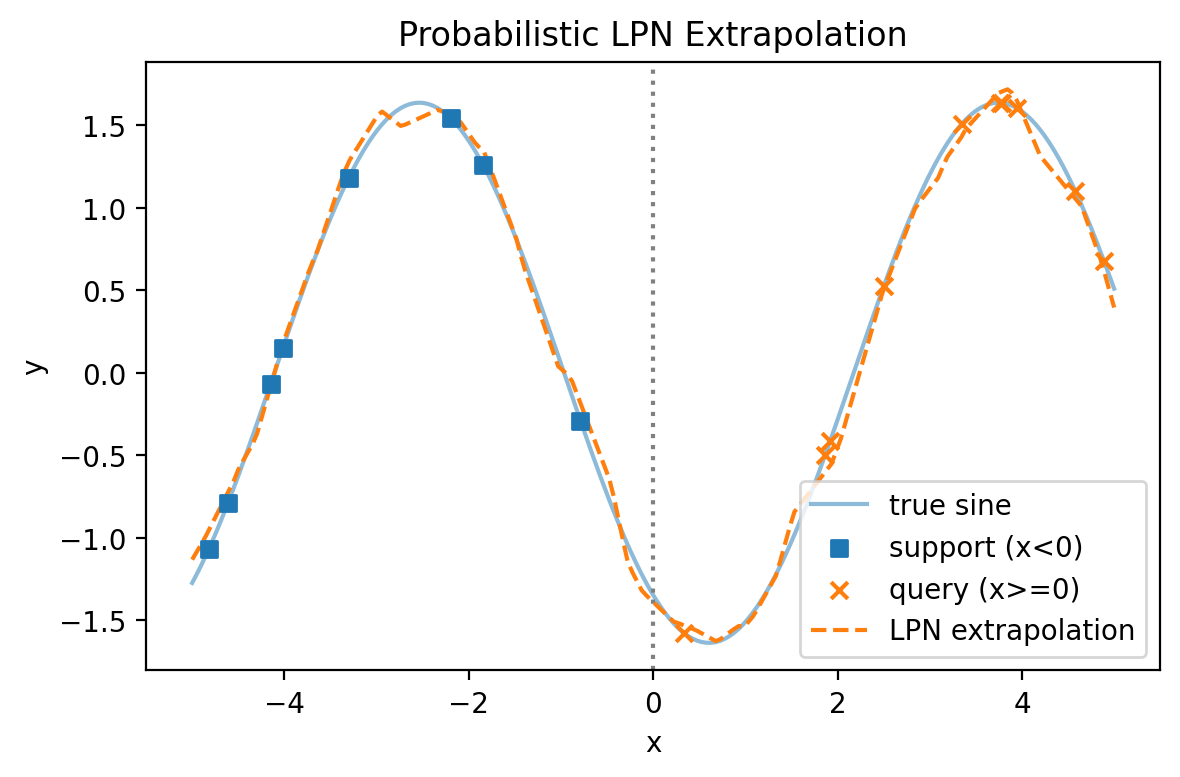

In [29]:
import matplotlib.pyplot as plt

# draw 10 support (x<0) and 10 query (x>=0)
data_gen = SineDataGenerator(num_samples_per_class=20, batch_size=1)
sup_xs, sup_ys, qry_xs, qry_ys, amp, phase = \
    generate_extrapolation_batch(data_gen, n_support=10, n_query=10)

# encode & refine on support only
support_pairs = torch.cat([sup_xs, sup_ys], dim=-1).to(device)
aux_t, _   = lpn(support_pairs, K=200, debug=True, deterministic=True)
z_traj     = aux_t["z_traj"]
z_final    = z_traj[-1].mean(dim=1).squeeze(0)  # your “best” latent

# predict on a fine grid for plotting
x_grid  = np.linspace(-5, 5, 200)
x_t     = torch.Tensor(x_grid).unsqueeze(1).to(device)
y_pred  = lpn.decode(z_final, x_t).detach().cpu().numpy().squeeze()

# now plot
plt.figure(figsize=(6,4))
plt.plot(x_grid, amp * np.sin(x_grid - phase),
         label='true sine', alpha=0.5)
plt.scatter(sup_xs.numpy(), sup_ys.numpy(),
            label='support (x<0)', marker='s', zorder=10)
plt.scatter(qry_xs.numpy(), qry_ys.numpy(),
            label='query (x>=0)', marker='x', zorder=10)
plt.plot(x_grid, y_pred, '--', label='LPN extrapolation', zorder=5)
plt.axvline(0, color='gray', linestyle=':')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Probabilistic LPN Extrapolation')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
test_xs[0, 0]

tensor([3.6262])

In [39]:
x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (100, 1)
x_prep.shape

torch.Size([200, 1])

In [40]:
z_sample[0, 0].shape

torch.Size([4])

### [WIP] Algorithm 1: Test-Time Inference

In [41]:
# # Input
# inputs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data_gen.generate()]
# # Context: n=10 input-output pairs (x_i, y_i)
# ctx_inputs = inputs[:, :-1, :]
# ctx_outputs = outputs_pred[:, :-1, :]
# # Test input x_{n+1}
# test_inputs = inputs[:, -1, :].unsqueeze(1)
# test_outputs = outputs_pred[:, -1, :].unsqueeze(1)
# number of gradient steps

### Plotting sample tasks

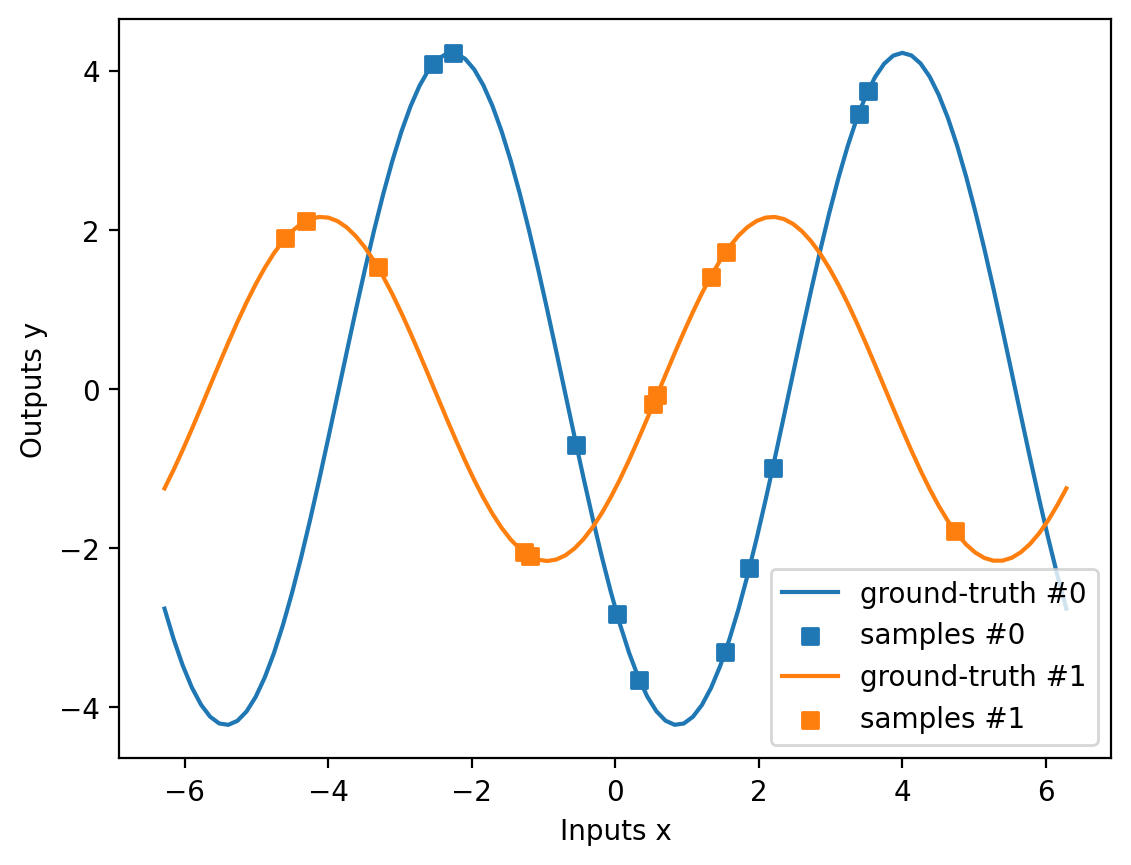

In [42]:
import matplotlib.pyplot as plt

# Plot each set of inputs and outputs as a separate line
for i in range(min(2, inputs_np.shape[0])):
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    
    # Convert PyTorch tensors to NumPy arrays
    if torch.is_tensor(amp_np[i]):
        amp_value = amp_np[i].detach().cpu().numpy()
    else:
        amp_value = amp_np[i]
        
    if torch.is_tensor(phase_np[i]):
        phase_value = phase_np[i].detach().cpu().numpy()
    else:
        phase_value = phase_np[i]
    
    y = amp_value * np.sin(x - phase_value)
    plt.plot(x, y, label=f"ground-truth #{i}")
    plt.scatter(inputs_np[i], outputs_np[i], marker='s', label=f"samples #{i}")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
plt.legend()
plt.show()

In [43]:
import matplotlib.pyplot as plt

# Plot each set of inputs and outputs as a separate line
for i in range(min(2, inputs_np.shape[0])):
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    y = amp_np[i] * np.sin(x - phase_np[i])
    plt.plot(x, y, label=f"ground-truth #{i}")
    plt.scatter(inputs_np[i], outputs_np[i], marker='s', label=f"samples #{i}")
    # plt.plot(init_inputs[i], outputs[i], label=f"Line {i+1}")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
# plt.title("Outputs vs Inputs")
plt.legend()
plt.show()

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'